-----------------------------------------------------------------------------------------------------------------------
# **Caso de Aplicación Árboles de Decisión**
-----------------------------------------------------------------------------------------------------------------------

------------------------------
## **Contexto**
------------------------------

Una Empresa del sector financiero desea implementar una estrategia de marketing que permita comunicar los cambios de política en uno de los beneficios que tiene su tarjeta de crédito. Actualmente, todos Bancos de la región se encuentran implementando políticas similares, por lo que es importante evaluar si esas políticas percudirán a sus clientes más valiosos. La hipótesis que se tiene es que como el beneficio en cuestión no tiene restricción, es usado por los clientes menos valiosos, y esto hace que mantenerlo no sea rentable.

------------------------------
## **Objetivo**
------------------------------

La institución solicita un análisis al área de datos con la finalidad de entender y analizar los clientes que han accedido al beneficio y el comportamiento que han tenido. Y de igual forma, proponer un escenario en el que se pueda restringir el uso y que clientes serían los afectados.

------------------------------
## **Descripción del Dataset**
------------------------------

Los datos entregados tienen relación al uso de los clientes en cuanto a un beneficio otorgado por el uso de su tarjeta de crédito. Se describe el Dataset como sigue:


| Variable | Descripción |
| -------- | ------------ |
| **ClienteId** | Identificador único del cliente. |
| **CostoEntrada** | Costo total que tiene el uso del beneficio. |
| **Año** | Año de acceso del beneficio. |
| **Mes** | Nivel de satisfación del cliente con la empresa |
| **Perfil Ingreso** | Tipo de cliente según la institución. |
| **PromedioConsumoMensual** | Promedio Consumo Mensual que ha tenido el cliente en su Tarjeta de crédito. |
| **Utilidad Financiera** | ngreso que el cliente ha dejado a la institución luego de restar los costos.|
| **SaldoCapital** | Valor de los consumos que tiene el cliente en su tarjeta de crédito en el momento de usar su beneficio.|

## **Importación de liberías y revisión de la base de datos**

In [1]:
%pip install openpyxl
%pip install prince
%pip install --upgrade typing_extensions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 6.2 MB/s eta 0:00:00


In [2]:
#Realizamos la importación de librería necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, max as spark_max, expr
from pyspark.sql.window import Window
from pyspark.sql.functions import ntile
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from prince import FAMD
from sklearn.decomposition import PCA
from pyspark.sql.functions import when, col, count, lit, min, max,round,concat_ws

In [3]:
#Realizamos la lectura del conjunto de datos descrito anteriormente
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_excel('/content/drive/MyDrive/dataAD.xlsx', na_values=['?'])
df.tail()

Mounted at /content/drive


,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,Mes,PerfilIngreso,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital
108637,33957,17.81,22900.0,1,2024,abril,PREFERENCIAL,21633.333,77.782,7329.11
108638,33958,22.40,25000.0,1,2024,abril,PERSONA CLUSTER 3,1387.208,8.891,1083.80
108639,33959,44.80,25000.0,2,2024,abril,PERSONA CLUSTER 3,1969.241,163.966,1655.43
108640,33960,44.80,25000.0,2,2024,abril,PERSONA CLUSTER 1,0.000,0.000,0.00
108641,33961,25.20,8100.0,1,2024,abril,PREFERENCIAL,5274.625,96.762,1718.82


In [4]:
# Realizamos un descriptivo de los principales indicadores estadísticos para las variables que son continuas
df1 = df.drop(columns=['Año'])
df1.describe().round(2)

,ClienteId,CostoEntrada,Cupo,EntradasMensuales,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital
count,108642.00,108642.00,108621.00,108642.00,108642.00,108642.00,108621.00
mean,16058.59,33.93,18140.63,1.73,15580.69,4198.57,7106.67
std,9571.02,22.46,14098.64,1.27,23849.01,5358.38,7694.73
min,1.00,16.80,20.00,1.00,0.00,-20820.38,0.00
25%,7754.00,17.81,11000.00,1.00,3249.16,580.46,1299.50
50%,15757.00,25.20,16200.00,1.00,10005.61,2118.39,4462.99
75%,24094.75,44.80,25000.00,2.00,20637.80,5798.76,10348.85
max,33961.00,672.37,800000.00,39.00,1521822.73,43396.94,171732.87


In [5]:
#Valores distintos para cada Cliente ID
distinct_count = df['ClienteId'].drop_duplicates().count()
distinct_count

np.int64(33961)


Al verificar los estadísticos de las variables que son continuas en el Dataset podemos observar, que existen **108,642** observaciones que se han entregado. Al observar la estructura de la tabla, vemos que se han entregado más de un registro por cliente. En la celda anterior, al hacer este ejercicio vemos que solo tenemos **33961 clientes** que han realizado 108,642 usos del beneficio.

Al analizar de igual forma la Data por cada año, vemos que tenemos observaciones desde el 2022 hasta el 2024. Es importante mencionar que tenemos **dos años completos (2022 - 2023) y un año parcial (2024)**.

In [6]:
# Verificamos cuantos meses de cada año se tiene

df_grouped = df.groupby('Año')['Mes'].nunique().reset_index(name='Distinct_Mes')
df_grouped

,Año,Distinct_Mes
0,2022,12
1,2023,12
2,2024,4


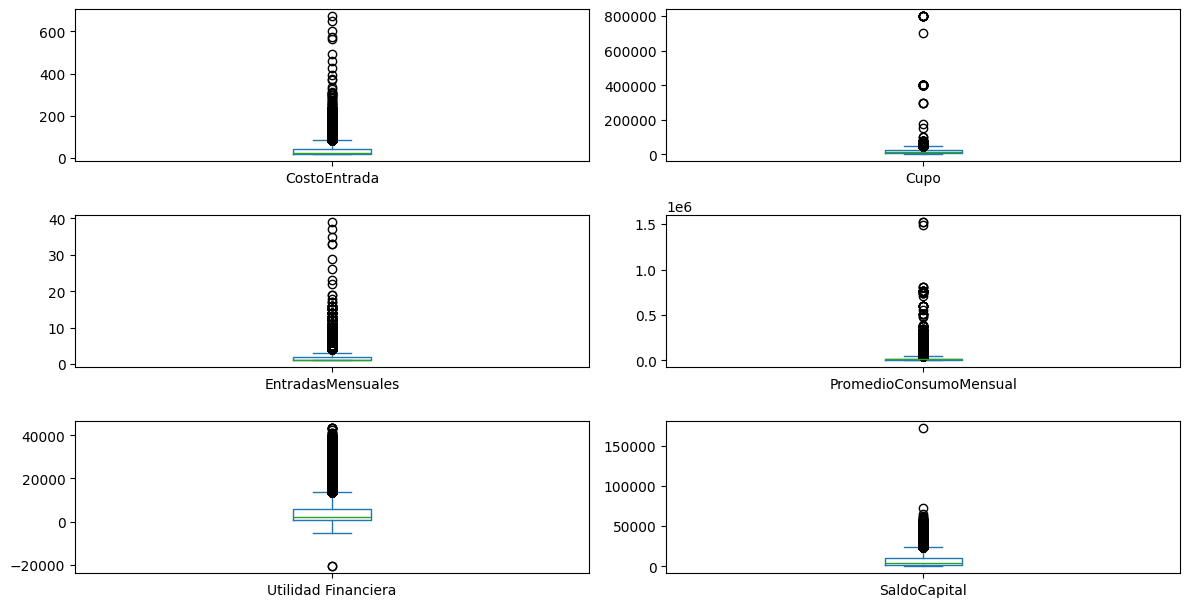

In [7]:
import matplotlib.pyplot as plt

# Drop the 'ClienteId' column
df1_filtered = df1.drop(columns=['ClienteId'])

# Generate box plots for the remaining variables
df1_filtered.plot(kind='box', subplots=True, layout=(int(len(df1_filtered.columns) / 2), 2), figsize=(12, 8), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Ahora considerando que los clientes tienen diferentes comportamientos de acuerdo a su realidad económica, se usa la variable perfil ingreso para repetir el ejercicio y verificar si existe comportamiento de valores atípicos y extremos. Como vemos en los gráficos inferiores, la tendencia se mantiene. Por lo que vamos a tener que retirar estas observaciones.

<Figure size 1000x600 with 0 Axes>

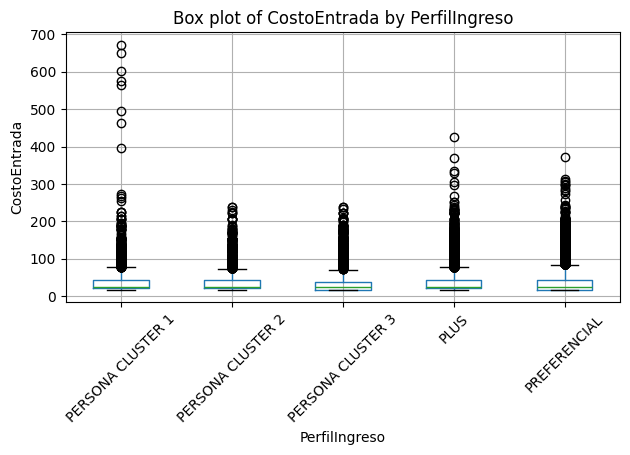

<Figure size 1000x600 with 0 Axes>

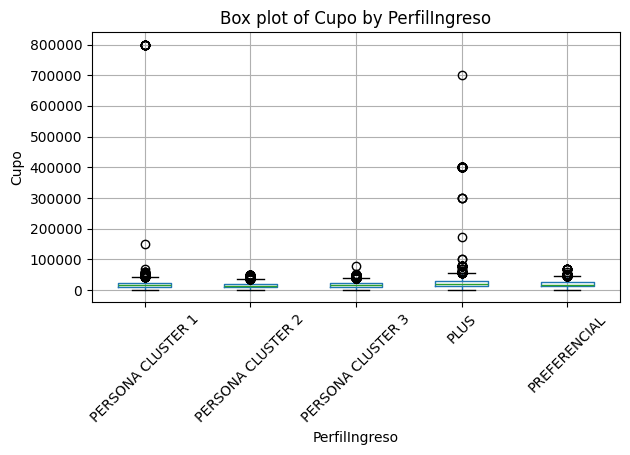

<Figure size 1000x600 with 0 Axes>

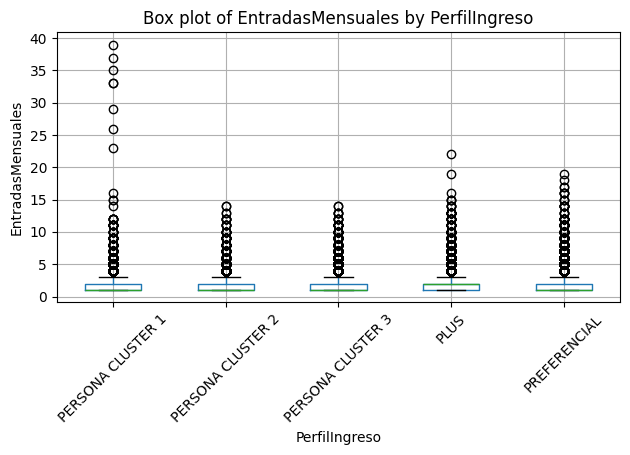

<Figure size 1000x600 with 0 Axes>

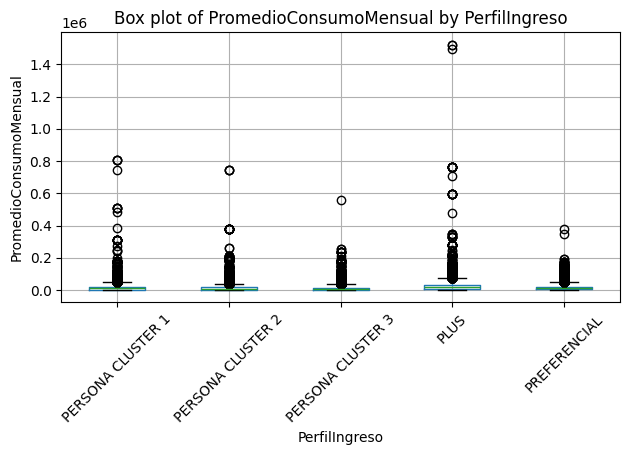

<Figure size 1000x600 with 0 Axes>

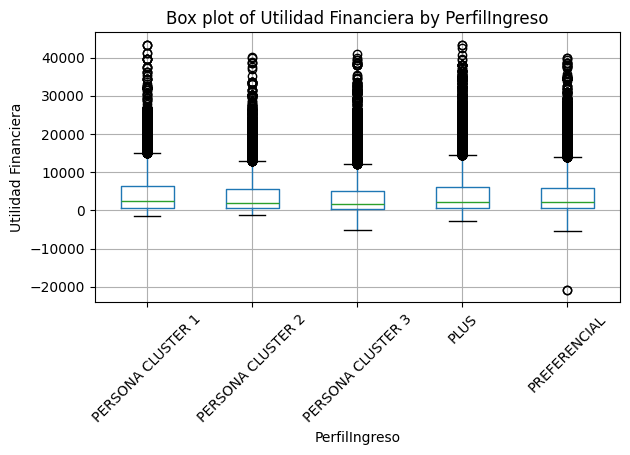

<Figure size 1000x600 with 0 Axes>

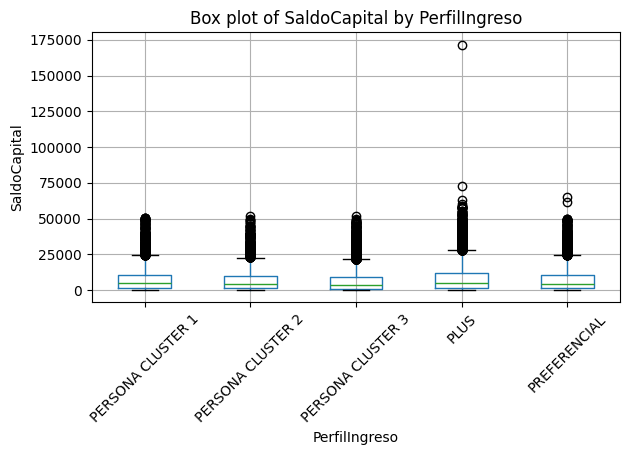

In [8]:
import matplotlib.pyplot as plt

# Drop the 'ClienteId' column
df1_filtered = df1.drop(columns=['ClienteId'])

# Generate box plots for continuous variables by 'PerfilIngreso' category
continuous_vars = df1_filtered.select_dtypes(include=['float64', 'int64']).columns
for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    df1_filtered.boxplot(column=var, by='PerfilIngreso')
    plt.title(f'Box plot of {var} by PerfilIngreso')
    plt.suptitle('')
    plt.xlabel('PerfilIngreso')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Si procedemos a realizar el ejercicio de quitar estos valores extremos tomando como definición de extremo aquel que sobrepasa 3 veces la distancia intercuatílica, tenemos un comportamiento mucho más normal para poder entender el comportamiento de uso del beneficio en los clientes.

In [9]:
def remove_outliers(df, group_col, value_cols):
    def outlier_bounds(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return lower_bound, upper_bound

    def filter_outliers(group):
        for col in value_cols:
            lower_bound, upper_bound = outlier_bounds(group[col])
            group = group[(group[col] >= lower_bound) & (group[col] <= upper_bound)]
        return group

    return df.groupby(group_col).apply(filter_outliers).reset_index(drop=True)

In [10]:
#Aplicamos la función para que se pueda tener datos mucho más suaves previo al modelado
value_columns=df.select_dtypes(include=['float64','int64']).columns
df_cleaned=remove_outliers(df,'PerfilIngreso',value_columns)

/tmp/ipython-input-9-3855598556.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(filter_outliers).reset_index(drop=True)


A diferencia de los diagramas de cajas y bigotes anteriores, se puede observar un comportamiento mucho más acotado a la realidad. Es importante observar que los clientes de mejor perfil tienden a tener mejores comportamientos en consumo, y cupo. Sin embargo, en uso del beneficio al parecer todos usan de la misma manera.

<Figure size 500x200 with 0 Axes>

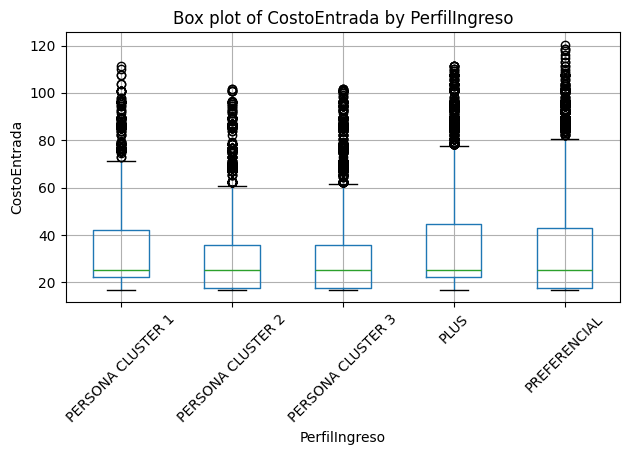

<Figure size 500x200 with 0 Axes>

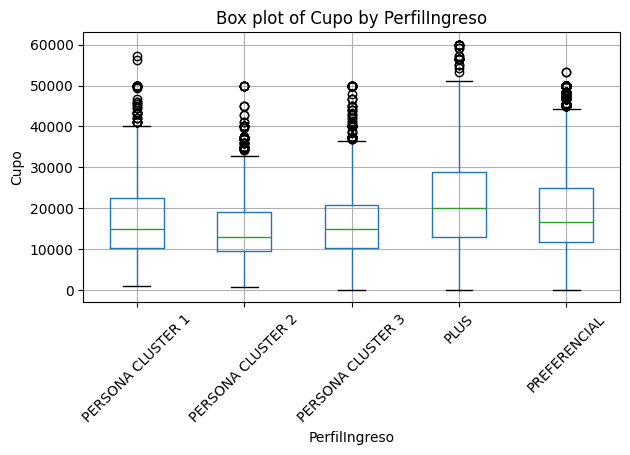

<Figure size 500x200 with 0 Axes>

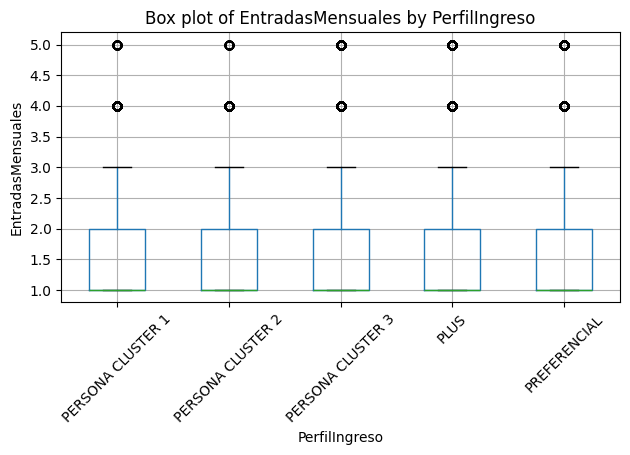

<Figure size 500x200 with 0 Axes>

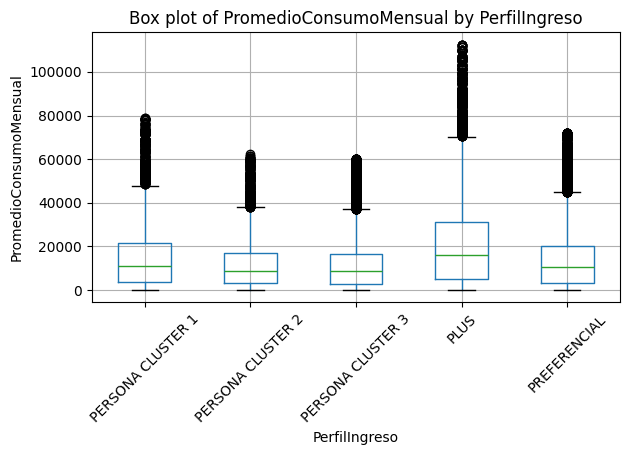

<Figure size 500x200 with 0 Axes>

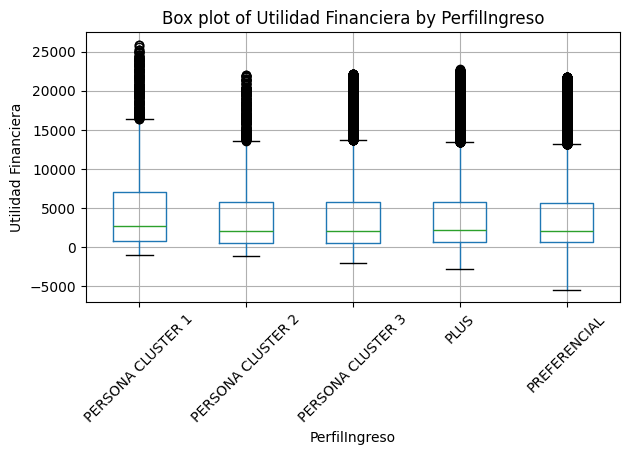

<Figure size 500x200 with 0 Axes>

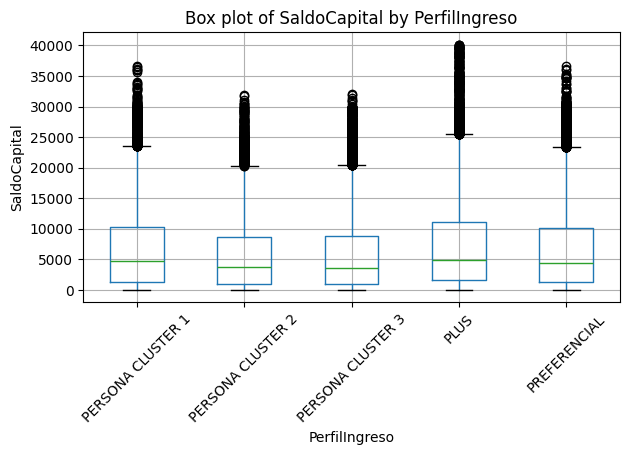

In [11]:
import matplotlib.pyplot as plt

# Drop the 'ClienteId' and 'Año' columns
df_cleaned_filtered = df_cleaned.drop(columns=['ClienteId', 'Año'])

# Generate box plots for continuous variables by 'PerfilIngreso' category
continuous_vars = df_cleaned_filtered.select_dtypes(include=['float64', 'int64']).columns
for var in continuous_vars:
    plt.figure(figsize=(5, 2))
    df_cleaned_filtered.boxplot(column=var, by='PerfilIngreso')
    plt.title(f'Box plot of {var} by PerfilIngreso')
    plt.suptitle('')
    plt.xlabel('PerfilIngreso')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

De igual forma si observamos las estadísticas principales para las variables analizadas, y las comparamos con las iniciales. Podemos ver un comportamiento mucha más normal en cuanto a máximos y mínimos.

In [12]:
df_cleaned.describe()
df.describe().round(2)

,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital
count,108642.00,108642.00,108621.00,108642.00,108642.00,108642.00,108642.00,108621.00
mean,16058.59,33.93,18140.63,1.73,2022.96,15580.69,4198.57,7106.67
std,9571.02,22.46,14098.64,1.27,0.67,23849.01,5358.38,7694.73
min,1.00,16.80,20.00,1.00,2022.00,0.00,-20820.38,0.00
25%,7754.00,17.81,11000.00,1.00,2023.00,3249.16,580.46,1299.50
50%,15757.00,25.20,16200.00,1.00,2023.00,10005.61,2118.39,4462.99
75%,24094.75,44.80,25000.00,2.00,2023.00,20637.80,5798.76,10348.85
max,33961.00,672.37,800000.00,39.00,2024.00,1521822.73,43396.94,171732.87


Una vez que hemos realizado la depuración de valores atípicos, procedemos a simplificar la correlación de las variables a través de un ACP, por lo que preparamos todo para que se pueda implementar como sigue:

Un ACP (Análisis de Componentes Principales), recibe variables numéricas, por lo que procedemos a realizar algunas transformaciones que permitan el uso de la función. Si no estas familiarizado con esta ténica, te dejo un link para puedas profundizar si lo necesitas. En resumen, permite consolodirar en variables numpericas denominadas componentes principlaes los efectos de más variables. En este caso, nuestra intención es poder resumir los efectos de las variables analizadas para generar una componente que permita identificar de mejor manera los mejores clientes.

In [13]:
def recategorizar_perfil_ingreso(producto):
    producto = producto.lower()
    if 'cluster 1' in producto:
        return  0
    elif '2' in producto:
        return 500
    elif '3' in producto:
        return 1000
    elif 'prefer' in producto:
        return 2500
    elif 'plus' in producto:
        return 6000

De igual forma, categorizamos de forma numérica el perfil ingreso tomando los rangos que tiene definido desde el negocio:

| Perfil Ingreso | Descripción |
| -------- | ------------ |
| **Cluster 1** |Personas que ganan hasta 500|
| **Cluster 2** | Ingresos de 500 hasta 1000|
| **Cluster 3** | Ingresos de 1000 hasta 2500 |
| **Preferente** | Ingresos de 2500 hasta 6000|
| **Plus** | Ingresos mayores a 6000|

In [14]:
# Aplicar la función a la columna 'SubProductoActivo'
df_cleaned['PerfilIngreso_cod'] = df_cleaned['PerfilIngreso'].apply(recategorizar_perfil_ingreso)
print(df_cleaned['PerfilIngreso_cod'] )

df_cleaned.groupby(['PerfilIngreso','PerfilIngreso_cod']).size()

#Obtenemos los nombres de variables en vectores para fácil manipulación.
num = ['PromedioConsumoMensual','EntradasMensuales','Cupo','Utilidad Financiera','SaldoCapital']
#cagnom=['Producto_cat']
cagord=['PerfilIngreso_cod']

0           0
1           0
2           0
3           0
4           0
         ... 
79560    2500
79561    2500
79562    2500
79563    2500
79564    2500
Name: PerfilIngreso_cod, Length: 79565, dtype: int64


Verificamos que todo se encuentra correcto para que no tengamos problemas en la interpretación o en la aplicación de los algoritmos. Es claro que para la codificación se han tomado los límites inferiores para tener un ordenamiento de menor a mejor ingreso. Esto refleja justamente la tabla inferior:

In [15]:
df_cleaned.groupby(['PerfilIngreso','PerfilIngreso_cod']).size()

,,0
PerfilIngreso,PerfilIngreso_cod,
PERSONA CLUSTER 1,0,7530
PERSONA CLUSTER 2,500,6125
PERSONA CLUSTER 3,1000,17649
PLUS,6000,16149
PREFERENCIAL,2500,32112


In [16]:
#Obtenemos los nombres de variables en vectores para fácil manipulación.
num = ['PromedioConsumoMensual','EntradasMensuales','Cupo','Utilidad Financiera','SaldoCapital']
#cagnom=['Producto_cat']
cagord=['PerfilIngreso_cod']

Hay que recordar que pese a que las variables numéricas pueden procesarse en un ACP, siempre es importante que se encuentren en la misma escala. Por lo que procedemos a escalar para que se puedan interpretar sin generar sesgos por la forma en la que se miden. Por ejemplo si comparamos entre el Monto Mensual Consumo y el Número de entradas, claramente un monto de $1000 será mucho más granda que 3 Entradas. Con el escalado, lo que hacemos es transformarlas para que se puedan comparar independiente de su unidad de medida.

In [17]:
# Columnas: num (variables numéricas), cagnom (variables categóricas nominales), cagord (variables categóricas ordinales)
# Preparación de datos:
# Escalado de variables numéricas
scaler = StandardScaler()
dfb = df_cleaned.copy()
dfb = dfb.dropna(subset=num + cagord)

dfb[num+ cagord] = scaler.fit_transform(dfb[num+ cagord])

# One-Hot Encoding para variables categóricas nominales
#encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
#encoded_nom = encoder.fit_transform(dfb[cagnom ])
#names_nom = encoder.get_feature_names_out(cagnom)

Revisamos que efectivamente el escalamiento de las variables numéricas sea el correcto de acuerdo a la función que hemos aplicado. Esto lo hacemos obteniendo una muestra de nuestro Dataframe.

In [18]:
dfb.head()

,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,Mes,PerfilIngreso,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital,PerfilIngreso_cod
0,14,25.20,-1.498382,-0.673164,2023,abril,PERSONA CLUSTER 1,3.349050,-0.751620,-0.378941,-1.261869
1,35,44.80,3.746248,0.428016,2023,noviembre,PERSONA CLUSTER 1,2.084751,-0.682875,0.761340,-1.261869
2,37,25.20,0.249828,-0.673164,2023,febrero,PERSONA CLUSTER 1,1.052908,-0.773867,-0.596091,-1.261869
3,48,44.80,0.249828,0.428016,2023,febrero,PERSONA CLUSTER 1,-0.978162,-0.858648,-0.946696,-1.261869
4,48,17.81,0.249828,-0.673164,2023,junio,PERSONA CLUSTER 1,-0.978162,-0.858648,-0.711100,-1.261869


Una vez que hemos verificado que todo se encuentra correcto, procedemos a realizar el análisis de componentes principales o ACP como sigue:

In [19]:
# Conversión a DataFrame para facilitar la integración
#encoded_nom_df = pd.DataFrame(encoded_nom, columns=names_nom, index=dfb.index)

# Concatenar variables numéricas, ordinales y codificadas nominales
prepared_df = pd.concat([dfb[num+ cagord]], axis=1)

pca_al = PCA()
pca_resultados = pca_al.fit_transform(prepared_df)

# Crear un DataFrame con los resultados de los componentes principales
columns = [f'PC{i+1}' for i in range(pca_al.n_components_)]
pca_df = pd.DataFrame(pca_resultados, columns=columns, index=dfb.index)

# Porcentaje de varianza explicada de cada componente
explained_variance_ratio = pca_al.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'Componente Principal': columns,
    'Porcentaje de Varianza Explicada': explained_variance_ratio * 100
})

# Visualización de resultados
# Varianza explicada acumulada
def plot_variance_explained(pca_al):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(pca_al.explained_variance_ratio_)+1),
             pca_al.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
    plt.title('Varianza explicada acumulada')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.grid()
    plt.show()

# Gráfico de las dos primeras componentes principales
def plot_pca_scatter(pca_df):
    plt.figure(figsize=(8, 5))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
    plt.title('Scatter Plot de las dos primeras componentes principales')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid()
    plt.show()


De igual forma es importante que podamos visualizar el porcentaje de varianza explicada por cada componente e incluso mirar el porcentaje acumulado si nos quedaramos con una o más componnentes. Para este caso en particular con 3 componentes explicamos casi el 72% de la varianza del conjunto de datos.


Eigenvalores (varianza explicada): [2.21225708 1.20327503 0.95690733 0.76954475 0.639895   0.21819621]

Proporción de varianza explicada: [0.36870488 0.20054332 0.15948255 0.12825585 0.10664783 0.03636558]

Varianza acumulada: [0.36870488 0.5692482  0.72873075 0.85698659 0.96363442 1.        ]

Resumen de la varianza explicada:
  Componente Principal  Varianza Explicada (%)  Varianza Acumulada (%)
0                 PCA1               36.870488               36.870488
1                 PCA2               20.054332               56.924820
2                 PCA3               15.948255               72.873075
3                 PCA4               12.825585               85.698659
4                 PCA5               10.664783               96.363442
5                 PCA6                3.636558              100.000000


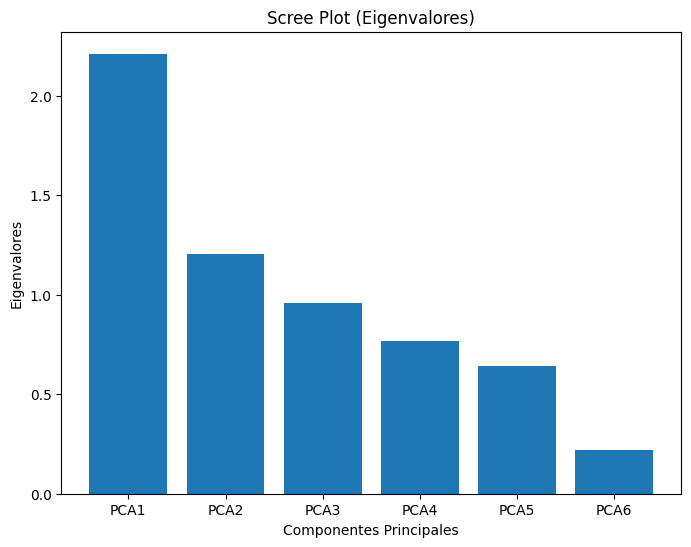

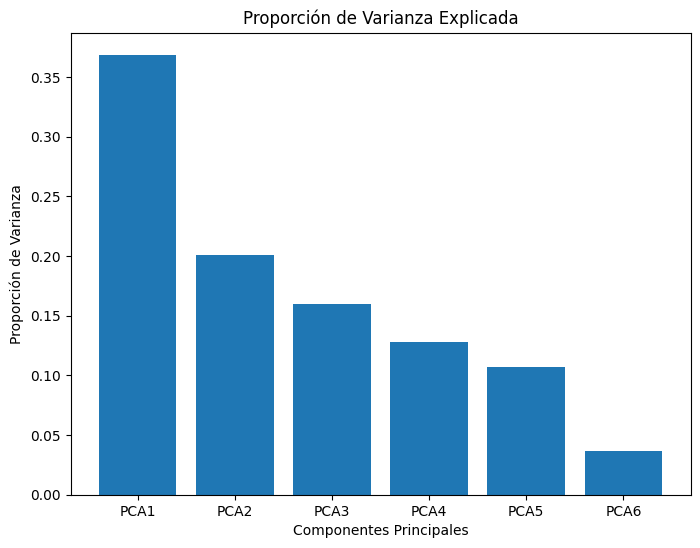

In [20]:
# Eigenvalores y porcentaje de varianza explicada
eigenvalues = pca_al.explained_variance_
explained_variance_ratio = pca_al.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("\nEigenvalores (varianza explicada):", eigenvalues)
print("\nProporción de varianza explicada:", explained_variance_ratio)
print("\nVarianza acumulada:", cumulative_variance_ratio)

# Crear un DataFrame para las proporciones de varianza
componentes_principales = [f"PCA{i+1}" for i in range(len(explained_variance_ratio))]
variance_df = pd.DataFrame({
    "Componente Principal": componentes_principales,
    "Varianza Explicada (%)": explained_variance_ratio * 100,
    "Varianza Acumulada (%)": cumulative_variance_ratio * 100
})

print("\nResumen de la varianza explicada:")
print(variance_df)

# Gráficos y análisis

# 1. Scree Plot (Eigenvalores)
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, tick_label=componentes_principales)
plt.title("Scree Plot (Eigenvalores)")
plt.xlabel("Componentes Principales")
plt.ylabel("Eigenvalores")
plt.show()

# 2. Varianza Explicada (Gráfico de Barras)
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, tick_label=componentes_principales)
plt.title("Proporción de Varianza Explicada")
plt.xlabel("Componentes Principales")
plt.ylabel("Proporción de Varianza")
plt.show()

# 3. Gráfico de cómo se relacionan los componentes con las variables originales
def plot_pca_loadings(pca, features):
    plt.figure(figsize=(10, 8))
    plt.quiver(np.zeros(pca.components_.shape[1]), np.zeros(pca.components_.shape[1]),
               pca.components_[0, :], pca.components_[1, :],
               angles='xy', scale_units='xy', scale=1, color='r')
    for i, feature in enumerate(features):
        plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15,
                 feature, color='g', ha='center', va='center')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Relación de las variables originales con los componentes principales   ')
    plt.grid()
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()


De igual forma, al visualizar las dos primeras componentes, y su relación con las variables que se ha intentado reducir, (ver último gráfico) podemos observar que se ubican todas sobre el eje positivo de la componente 1, mientras que en la componente 2 se contraponen entre los ejes positivo y negativo. Esto se puede interpretar: clientes con mayor uso del beneficio,tienen menos saldo o utilidad, lo cual nos da una pauta que se puede optimizar costos si hacemos que el beneficio esté vinculado a clientes más valiosos o rentables.

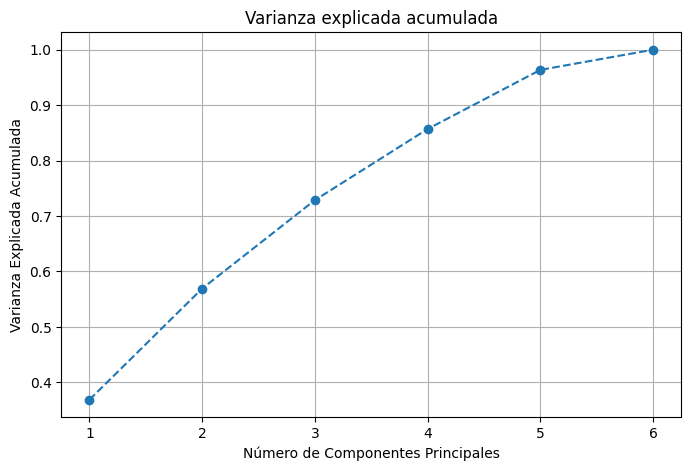

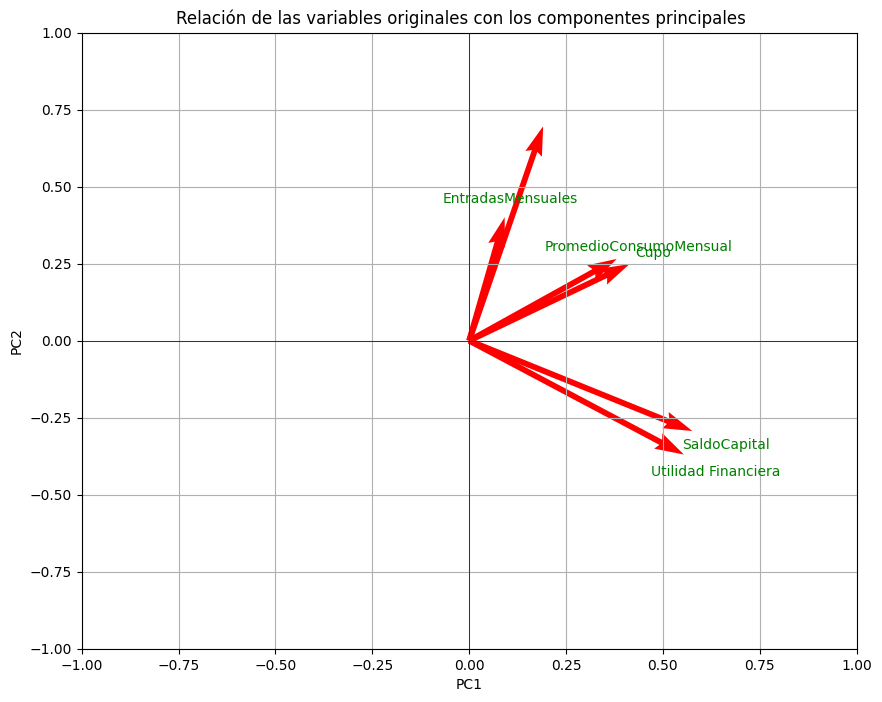

In [21]:
#Llamar a las funciones de visualización
plot_variance_explained(pca_al)
#plot_pca_scatter(pca_df)
plot_pca_loadings(pca_al, num)


In [22]:
loadings = pd.DataFrame(pca_al.components_.T, columns=columns, index=prepared_df.columns)

suma_columnas = loadings.abs().sum() # Calcular el porcentaje de cada valor en las columnas
porcentaje_columnas = loadings.div(suma_columnas, axis=1).abs()  # Ver el resultado
porcentaje_columnas.style.format('{:.0%}')

,PC1,PC2,PC3,PC4,PC5,PC6
PromedioConsumoMensual,17%,12%,1%,48%,12%,2%
EntradasMensuales,4%,18%,52%,9%,4%,0%
Cupo,19%,11%,17%,27%,32%,4%
Utilidad Financiera,25%,16%,7%,2%,11%,44%
SaldoCapital,26%,13%,4%,7%,11%,45%
PerfilIngreso_cod,9%,31%,18%,7%,29%,4%


Agregamos las componenentes principales a nuestro conjunto de datos, porque serán necesarias para tener en una variable simple la representación de los efecto de algunas variables.

In [23]:

for i in range(5):
    df_cleaned[f'PCA{i+1}'] = pca_resultados[:, i]

Ahora bien, vamos a trabajar en una propuesta que nos permita el ahorro de costos hacia la institución financiera. Importante mencionar que con el ACP, sabemos que la componente 2, permite tener un descriptivo de alguna forma de como se comportan los clientes en las variables analizadas. Mas que nada podemos tener comportamiento positivos, entre mayor es la componente mejor es el cliente. Usaremos esta variable junto con una nueva **Entradas Anuales**, para generar el escenario de a que clientes restringiremos y el ahorro que podríamos generar anualmente.

In [24]:
meses_mapping = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
    'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}
df_cleaned['Mes'] = df_cleaned['Mes'].map(meses_mapping)

In [25]:
df_cleaned = df_cleaned.sort_values(by=['ClienteId', 'Año', 'Mes'], ascending=True)
df_cleaned['Entradas_Acumuladas_Anual'] = df_cleaned.groupby(['ClienteId', 'Año'])['EntradasMensuales'].cumsum()

df_cleaned.head()

,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,Mes,PerfilIngreso,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital,PerfilIngreso_cod,PCA1,PCA2,PCA3,PCA4,PCA5,Entradas_Acumuladas_Anual
31304,1,25.20,10000.0,1,2022,4,PLUS,615.925,21.653,15.99,6000,-1.486337,1.092906,-1.020603,-0.323598,-1.558197,1
31305,2,25.20,20000.0,1,2023,6,PLUS,8059.425,201.999,955.57,6000,-0.716698,1.458885,-1.365551,-0.480696,-0.692310,1
31306,3,25.20,15000.0,1,2022,3,PLUS,24980.558,2021.901,6277.09,6000,0.130615,1.238806,-1.114068,0.635216,-1.066724,1
31307,3,25.20,15000.0,1,2022,8,PLUS,24980.558,2021.901,3992.30,6000,-0.060990,1.336339,-1.137945,0.675839,-0.988132,2
31311,4,51.41,50000.0,3,2022,12,PLUS,12198.625,5709.664,11724.81,6000,2.595086,2.386050,-0.192822,-2.504447,1.232666,3


Para un mejor entendimiento y dado que las variables son continuas, haremos cortes usando por un lado grupos definidos para Entradas Anuales y los percentiles para la componente principal. Los expondremos en un mapa de calor para poder decidir el escenario más interesante.

In [26]:
# Definir los límites manuales para la agrupación
bins = [1, 2, 3, 4, 5, 6, 8, 12, 18, 200]
labels = ['1', '2', '3', '4', '5', '6-7', '8-11', '12-17', '18mas']

# Crear la nueva variable 'Entradas_Acumuladas_Anual_Grupo' en el DataFrame dfb
df_cleaned['Entradas_Acumuladas_Anual_Grupo'] = pd.cut(df_cleaned['Entradas_Acumuladas_Anual'], bins=bins, labels=labels, right=False)

df_cleaned.head()

,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,Mes,PerfilIngreso,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital,PerfilIngreso_cod,PCA1,PCA2,PCA3,PCA4,PCA5,Entradas_Acumuladas_Anual,Entradas_Acumuladas_Anual_Grupo
31304,1,25.20,10000.0,1,2022,4,PLUS,615.925,21.653,15.99,6000,-1.486337,1.092906,-1.020603,-0.323598,-1.558197,1,1
31305,2,25.20,20000.0,1,2023,6,PLUS,8059.425,201.999,955.57,6000,-0.716698,1.458885,-1.365551,-0.480696,-0.692310,1,1
31306,3,25.20,15000.0,1,2022,3,PLUS,24980.558,2021.901,6277.09,6000,0.130615,1.238806,-1.114068,0.635216,-1.066724,1,1
31307,3,25.20,15000.0,1,2022,8,PLUS,24980.558,2021.901,3992.30,6000,-0.060990,1.336339,-1.137945,0.675839,-0.988132,2,2
31311,4,51.41,50000.0,3,2022,12,PLUS,12198.625,5709.664,11724.81,6000,2.595086,2.386050,-0.192822,-2.504447,1.232666,3,3


In [27]:
#Comprobando que todo esta OK
df_cleaned.groupby("Entradas_Acumuladas_Anual_Grupo")["Entradas_Acumuladas_Anual"].agg(['min', 'max'])

/tmp/ipython-input-27-3447281335.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned.groupby("Entradas_Acumuladas_Anual_Grupo")["Entradas_Acumuladas_Anual"].agg(['min', 'max'])


,min,max
Entradas_Acumuladas_Anual_Grupo,,
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6-7,6,7
8-11,8,11
12-17,12,17
18mas,18,56


In [28]:
# Crear percentiles para PCA1 y PCA2
df_cleaned['PCA1_percentile'] = pd.qcut(df_cleaned['PCA1'], 10, labels=False)
df_cleaned['PCA2_percentile'] = pd.qcut(df_cleaned['PCA2'], 10, labels=False)

df_cleaned.head()

,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,Mes,PerfilIngreso,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital,PerfilIngreso_cod,PCA1,PCA2,PCA3,PCA4,PCA5,Entradas_Acumuladas_Anual,Entradas_Acumuladas_Anual_Grupo,PCA1_percentile,PCA2_percentile
31304,1,25.20,10000.0,1,2022,4,PLUS,615.925,21.653,15.99,6000,-1.486337,1.092906,-1.020603,-0.323598,-1.558197,1,1,1,8
31305,2,25.20,20000.0,1,2023,6,PLUS,8059.425,201.999,955.57,6000,-0.716698,1.458885,-1.365551,-0.480696,-0.692310,1,1,3,8
31306,3,25.20,15000.0,1,2022,3,PLUS,24980.558,2021.901,6277.09,6000,0.130615,1.238806,-1.114068,0.635216,-1.066724,1,1,6,8
31307,3,25.20,15000.0,1,2022,8,PLUS,24980.558,2021.901,3992.30,6000,-0.060990,1.336339,-1.137945,0.675839,-0.988132,2,2,5,8
31311,4,51.41,50000.0,3,2022,12,PLUS,12198.625,5709.664,11724.81,6000,2.595086,2.386050,-0.192822,-2.504447,1.232666,3,3,9,9


En los mapas de calor inferiores, podemos observar que el comportamiento del número de entradas o accesos al benefecio versus la componenete principal, podemos observar que los clientes que tienen menor valor de la componenente principal acceden en menor proporción que aquellos que tienen valores más altos, si recordamos la interpretación podemos concluir que los clientes menos valiosos son aquellos que estan haciendo uso del beneficio.

/tmp/ipython-input-29-3523216921.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_cleaned.pivot_table(index='Entradas_Acumuladas_Anual_Grupo', columns='PCA2_percentile', aggfunc='size', fill_value=0)


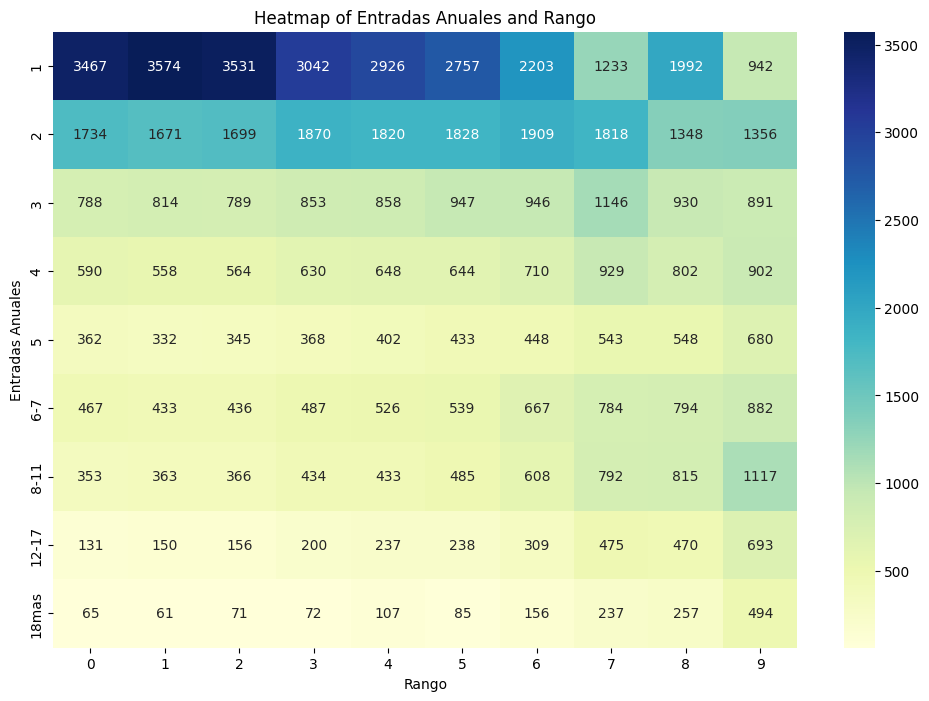

In [29]:
# Create a pivot table for the heatmap Número
pivot_table = df_cleaned.pivot_table(index='Entradas_Acumuladas_Anual_Grupo', columns='PCA2_percentile', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Entradas Anuales and Rango')
plt.xlabel('Rango')
plt.ylabel('Entradas Anuales')
plt.show()

De igual manera, si mantenemos el razonamiento anterior, pero ahora miramos el costo que está teniendo la entidad para este beneficio, vemos que está concentrado en monto en aquellos clientes con mejores perfiles; sin embargo, hay un monto importante en aquellos que acceden muchas veces y además no representan un buen cliente para la institución.

/tmp/ipython-input-30-1935404788.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_cleaned.pivot_table(


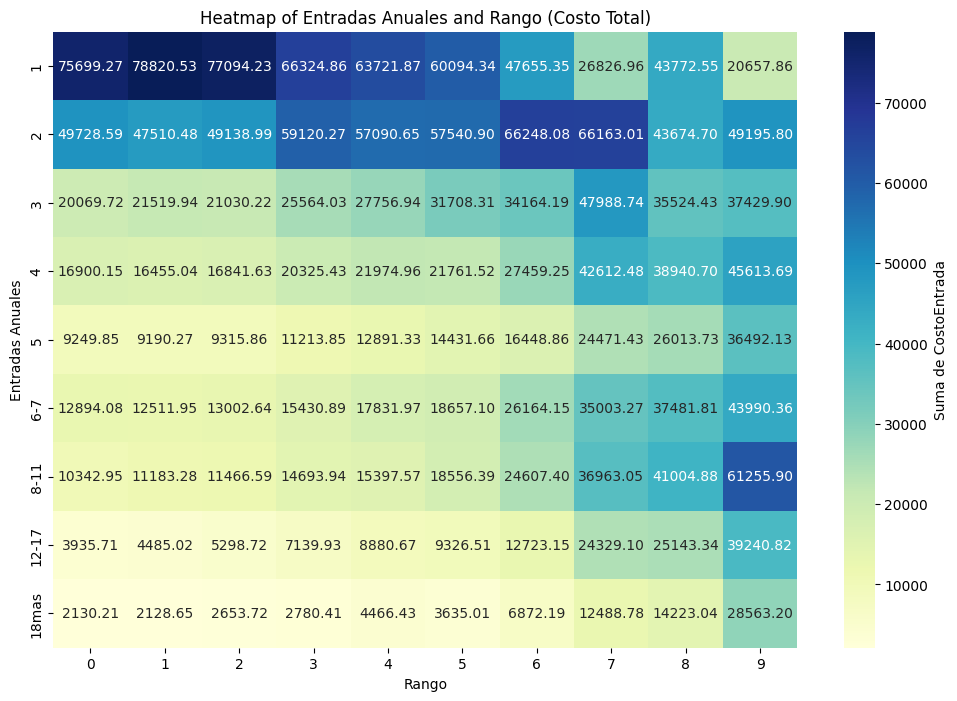

In [30]:
pivot_table = df_cleaned.pivot_table(
    index='Entradas_Acumuladas_Anual_Grupo',
    columns='PCA2_percentile',
    values='CostoEntrada',
    aggfunc='sum',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Suma de CostoEntrada'})
plt.title('Heatmap of Entradas Anuales and Rango (Costo Total)')
plt.xlabel('Rango')
plt.ylabel('Entradas Anuales')
plt.show()


Tomando en cuenta lo que hemos observado en los mapas de calor, podemos generar una regla para poder de alguna forma restringir el uso del beneficio a aquellos clientes que no representan un buen perfil para la institución. Dado que queremos enfocarnos en una reducción de costos, tomamos aquellos que tienen menos de 4 entradas al año y de igual forma quienes no llegan a tener un valor en la componente principal 2 mayor a u percentil 4.

In [31]:
df_cleaned['Restriccion1'] = ((df_cleaned['PCA2'] < 4) & (df_cleaned['Entradas_Acumuladas_Anual'] < 4)).astype(int)

Generando esta restrcción que a la final impide que ciertos clientes hagan uso del beneficio, podemos estimar el ahorro que podría haberse generado si la institución implementaba esta política.

In [32]:
dfb_grouped1 = df_cleaned.groupby(['Restriccion1', 'Año']).agg(
    total_filas=('ClienteId', 'size'),
    total_clientes_unicos=('ClienteId', 'nunique'),
    suma_CostoEntrada=('CostoEntrada', 'sum'),
    suma_Entradas_Acumuladas_Anual=('EntradasMensuales', 'sum')
).reset_index()
dfb_grouped1

,Restriccion1,Año,total_filas,total_clientes_unicos,suma_CostoEntrada,suma_Entradas_Acumuladas_Anual
0,0,2022,4903,1878,204368.94,10884
1,0,2023,20675,7593,824174.28,43629
2,0,2024,2305,1398,108945.38,6083
3,1,2022,7951,5748,220297.27,10661
4,1,2023,35544,24773,959012.39,45788
5,1,2024,8187,6668,229526.05,11159


Como podemos observar en la tabla anterior, cuando la restricción es positiva, vemos un ahorro de 29k en 2024, y de casi 400k, en 2023. Ahora bien es importante describir a que clientes estamos perjudicando de alguna manera, y para ello usaremos árboles de decisión. En los códigos siguinetes se encuentran dos maneras de abrodar este problema, y se complementa también con la búsqueda del mejor modelo a través de la librería **GridSearchCV**. De igual forma, la variable que se quiere predecir es la **Restricción**; sin embargo, abordamos dos maneras de calcular un árbol sin balanceo de las categorías (1 y 0) y balanceando con muestreo las mismas.

Mejores parámetros encontrados por GridSearchCV:
{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.52      0.13      0.21      8211
           1       0.67      0.94      0.78     15659

    accuracy                           0.66     23870
   macro avg       0.59      0.53      0.50     23870
weighted avg       0.62      0.66      0.58     23870


Precisión en el conjunto de prueba: 0.6586929199832425


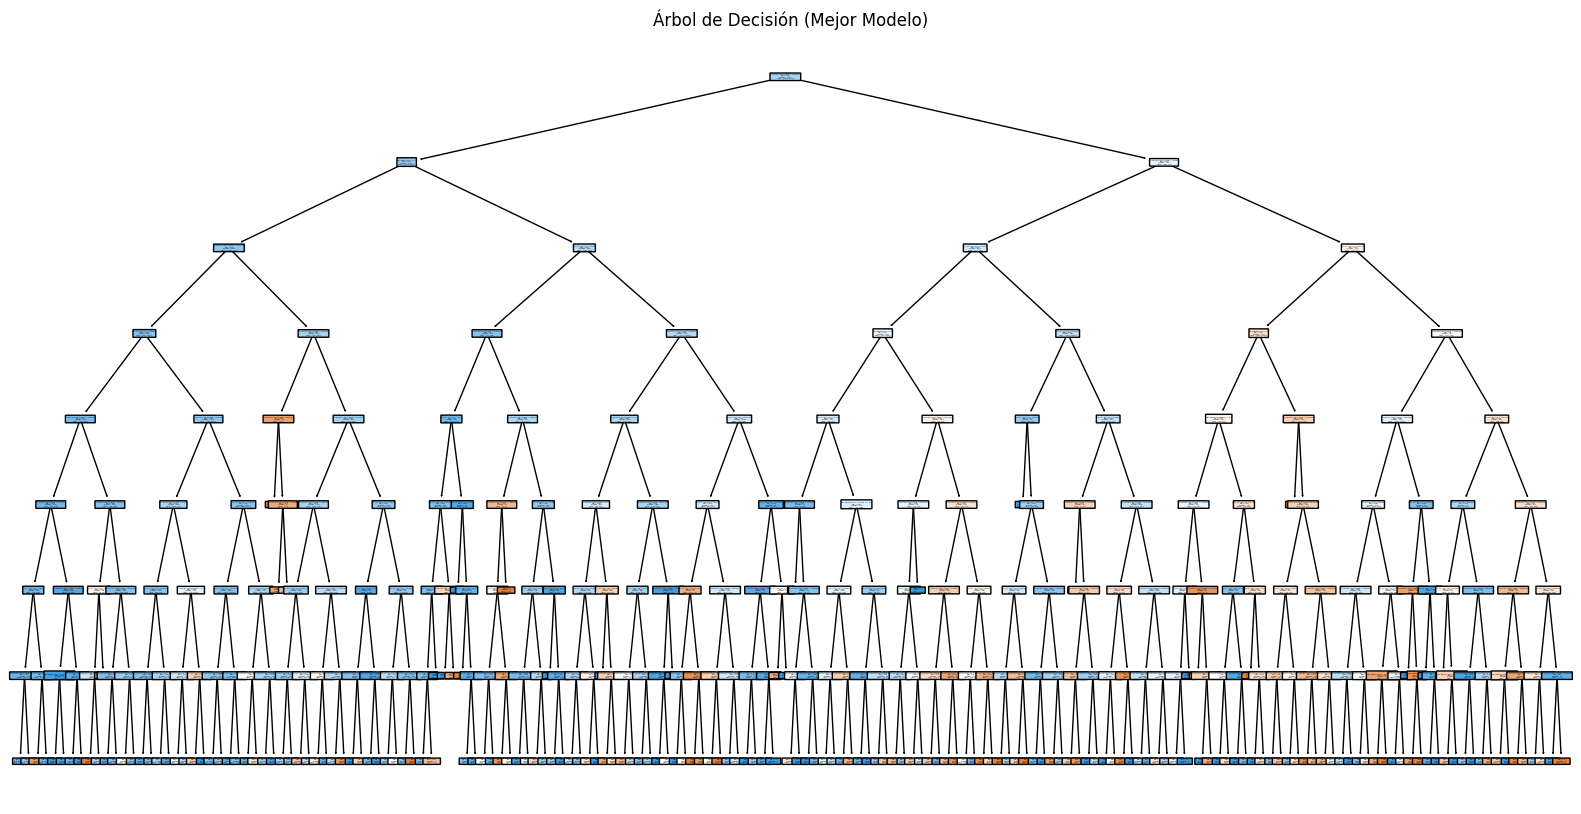


Importancia de las características:


,importance
PromedioConsumoMensual,0.670891
Utilidad Financiera,0.259896
PerfilIngreso_PLUS,0.060391
PerfilIngreso_PREFERENCIAL,0.004924
PerfilIngreso_PERSONA CLUSTER 2,0.003277
PerfilIngreso_PERSONA CLUSTER 3,0.000621


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
# Preparar los datos para el árbol de decisión
# Definir las variables predictoras (X) y la variable objetivo (y)
# Se excluyen variables que no serían predictoras directas del uso del beneficio
# o que están relacionadas con la propia definición de Restriccion1 (como PCAi y Entradas_Acumuladas_Anual)
features = ['PerfilIngreso','PromedioConsumoMensual', 'Utilidad Financiera']
target = 'Restriccion1'

# Asegurarse de que todas las columnas necesarias existen en df_cleaned
missing_cols = [col for col in features if col not in df_cleaned.columns]
if missing_cols:
    raise ValueError(f"Columnas faltantes en df_cleaned: {missing_cols}")

X = df_cleaned[features].copy()
y = df_cleaned[target]

# Identificar columnas categóricas para codificación
categorical_features = ['PerfilIngreso']
# Numericas para estandarizacion si es necesario (el arbol no lo requiere directamente, pero es buena practica)
numerical_features = [col for col in features if col not in categorical_features]


# Codificación de variables categóricas
# Usaremos One-Hot Encoding para 'Año', 'Mes', 'Perfil Ingreso'
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar y entrenar el árbol de decisión
# Usamos un clasificador para la variable binaria Restriccion1
tree_clf = DecisionTreeClassifier(random_state=42)

# Definir la cuadrícula de parámetros para GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Inicializar GridSearchCV
grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_tree_clf = grid_search.best_estimator_

print("Mejores parámetros encontrados por GridSearchCV:")
print(best_params)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_tree_clf.predict(X_test)

print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))

print("\nPrecisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

# Visualizar el árbol de decisión (opcional, solo si el árbol no es demasiado grande)
# Puedes ajustar max_depth para controlar el tamaño de la visualización
plt.figure(figsize=(20, 10))
plot_tree(best_tree_clf, feature_names=X.columns.tolist(), class_names=['No Restriccion1', 'Restriccion1'], filled=True, rounded=True)
plt.title("Árbol de Decisión (Mejor Modelo)")
plt.show()

# Mostrar la importancia de las características
feature_importances = pd.DataFrame(best_tree_clf.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print("\nImportancia de las características:")
feature_importances


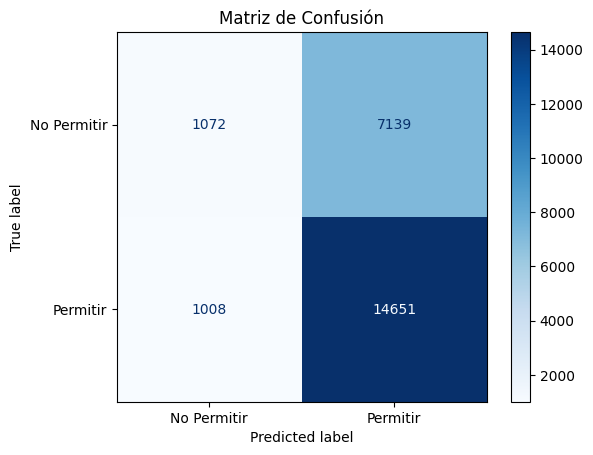

In [34]:
# Mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=best_tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Permitir", "Permitir"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

Ahora bien, si solo nos fijaramos en el indicador de accurracy, podríamos concluir que el modelo ajusta adecuademnte la predicción de la restricción de uso del beneficio ya que tiene valores cercanos a 1. Pero si observamos los demás indicadores como F1 score y recall vemos que el en general el modelo se equivoca fuertemente cuando un cliente no debe acceder al beneficio. Y por el contrario en aquellos que acceden,  claramente los indicadores son superiores lo que hace que tengamos conclusiones equivocadas.

In [35]:
# prompt: imprime las reglas de best_tree_clf

from sklearn.tree import export_text

# Imprimir las reglas del mejor árbol de decisión
print("\nReglas del mejor árbol de decisión:")
print(export_text(best_tree_clf, feature_names=X.columns.tolist()))


Reglas del mejor árbol de decisión:
|--- PromedioConsumoMensual <= 21225.91
|   |--- PerfilIngreso_PLUS <= 0.50
|   |   |--- PromedioConsumoMensual <= 12797.12
|   |   |   |--- Utilidad Financiera <= 438.83
|   |   |   |   |--- PromedioConsumoMensual <= 2926.24
|   |   |   |   |   |--- PromedioConsumoMensual <= 2731.42
|   |   |   |   |   |   |--- Utilidad Financiera <= 48.29
|   |   |   |   |   |   |   |--- PromedioConsumoMensual <= 1802.70
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- PromedioConsumoMensual >  1802.70
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Utilidad Financiera >  48.29
|   |   |   |   |   |   |   |--- Utilidad Financiera <= 48.34
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Utilidad Financiera >  48.34
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- PromedioConsumoMensual >  2731.42
|   |   |   |   |   |   |--- PromedioConsumoMensual <= 2795.0

De igual forma con el código anterior podemos observar las reglas que el modelo ha planteado en cuanto a los cortes de las variables usadas como predictoras.

Ahora bien, vamos a realizar el mismo ejercicio pero considerando una muestra balanceada para la variable Restricción:

In [36]:
# prompt: balancea el conjunto df_cleaned con respecto a Restriccion1, para que tenga una muestra 50/50 de cada categoria de Restriccion1

import pandas as pd
# Balancear el conjunto de datos df_cleaned con respecto a 'Restriccion1'
# para tener una muestra 50/50 de cada categoría.

# Contar el número de muestras en cada categoría de 'Restriccion1'
count_class_0, count_class_1 = df_cleaned['Restriccion1'].value_counts()

# Separar las clases
df_class_0 = df_cleaned[df_cleaned['Restriccion1'] == 0]
df_class_1 = df_cleaned[df_cleaned['Restriccion1'] == 1]

# Determinar el número de muestras a tomar de cada clase para el balanceo 50/50
# Tomaremos el mínimo entre el número de muestras en la clase minoritaria para evitar sobremuestreo simple
min_samples = count_class_1

# Muestreo aleatorio con el mismo número de muestras de cada clase
df_class_0_balanced = df_class_0.sample(min_samples, random_state=42)
df_class_1_balanced = df_class_1.sample(min_samples, random_state=42)

# Concatenar las muestras balanceadas para crear el nuevo DataFrame balanceado
df_cleaned_balanced = pd.concat([df_class_0_balanced, df_class_1_balanced], axis=0)

# Opcional: Mezclar el DataFrame balanceado para asegurar que las clases no estén ordenadas
df_cleaned_balanced = df_cleaned_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la distribución en el DataFrame balanceado
print("Distribución de Restriccion1 en el conjunto balanceado:")
print(df_cleaned_balanced['Restriccion1'].value_counts())

# Opcional: Mostrar las primeras filas del DataFrame balanceado
print("\nPrimeras filas del conjunto balanceado:")
df_cleaned_balanced.head()


Distribución de Restriccion1 en el conjunto balanceado:
Restriccion1
1    27883
0    27883
Name: count, dtype: int64

Primeras filas del conjunto balanceado:


,ClienteId,CostoEntrada,Cupo,EntradasMensuales,Año,Mes,PerfilIngreso,PromedioConsumoMensual,Utilidad Financiera,SaldoCapital,...,PCA1,PCA2,PCA3,PCA4,PCA5,Entradas_Acumuladas_Anual,Entradas_Acumuladas_Anual_Grupo,PCA1_percentile,PCA2_percentile,Restriccion1
0,27972,25.20,21200.0,1,2024,1,PREFERENCIAL,1.24049,3125.763,10990.38,...,-0.010629,-0.544450,-0.674515,-0.973705,-0.154021,1,1,5,3,1
1,21938,51.41,15000.0,3,2023,6,PREFERENCIAL,15690.07500,8446.329,11805.97,...,0.988746,-0.024613,1.632226,-0.166658,-0.500352,4,4,7,5,0
2,15355,33.60,12000.0,2,2023,2,PLUS,17590.18300,347.544,1148.80,...,-0.728494,1.815225,-0.111912,0.308087,-1.083394,3,3,3,9,1
3,17385,22.40,14500.0,1,2023,12,PERSONA CLUSTER 2,26971.91600,6166.331,9830.49,...,0.415451,-1.164367,-0.106695,1.030671,0.288045,4,4,6,1,0
4,3432,25.20,25000.0,1,2024,1,PLUS,2434.66600,1276.262,3856.52,...,-0.245716,1.296077,-1.472799,-1.130187,-0.553551,1,1,5,8,1


Mejores parámetros encontrados por GridSearchCV:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      8407
           1       0.68      0.74      0.71      8323

    accuracy                           0.70     16730
   macro avg       0.70      0.70      0.70     16730
weighted avg       0.70      0.70      0.70     16730


Precisión en el conjunto de prueba: 0.6961147638971906


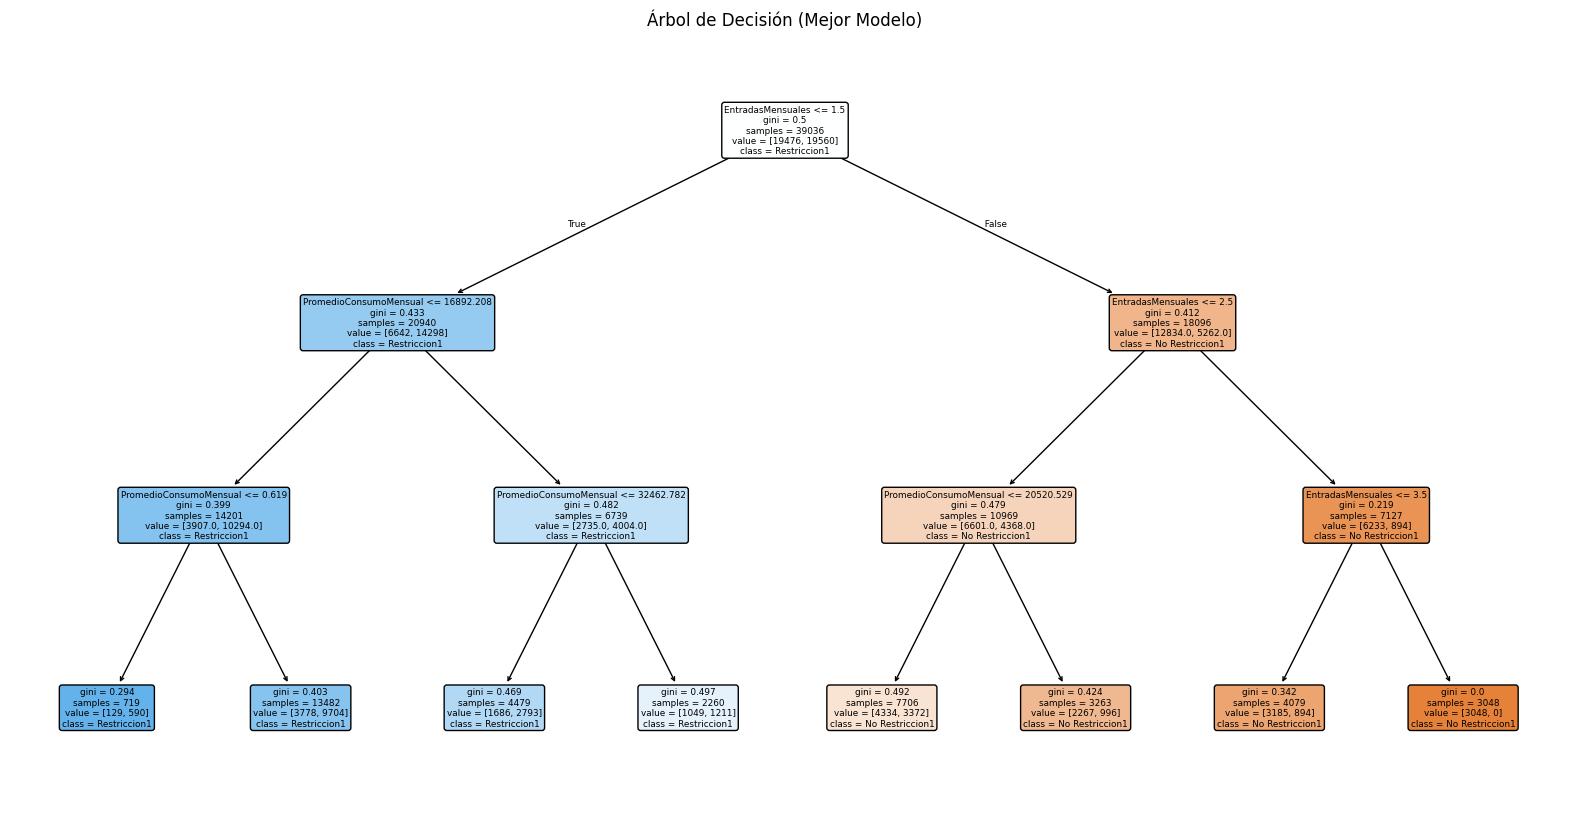


Importancia de las características:


,importance
EntradasMensuales,0.932763
PromedioConsumoMensual,0.067237
PerfilIngreso_PERSONA CLUSTER 2,0.000000
PerfilIngreso_PERSONA CLUSTER 3,0.000000
PerfilIngreso_PLUS,0.000000
PerfilIngreso_PREFERENCIAL,0.000000


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
# Preparar los datos para el árbol de decisión
# Definir las variables predictoras (X) y la variable objetivo (y)
# Se excluyen variables que no serían predictoras directas del uso del beneficio
# o que están relacionadas con la propia definición de Restriccion1 (como PCAi y Entradas_Acumuladas_Anual)
features = ['PerfilIngreso','PromedioConsumoMensual', 'EntradasMensuales']
target = 'Restriccion1'

# Asegurarse de que todas las columnas necesarias existen en df_cleaned
missing_cols = [col for col in features if col not in df_cleaned_balanced.columns]
if missing_cols:
    raise ValueError(f"Columnas faltantes en df_cleaned: {missing_cols}")

X = df_cleaned_balanced[features].copy()
y = df_cleaned_balanced[target]

# Identificar columnas categóricas para codificación
categorical_features = ['PerfilIngreso']
# Numericas para estandarizacion si es necesario (el arbol no lo requiere directamente, pero es buena practica)
numerical_features = [col for col in features if col not in categorical_features]


# Codificación de variables categóricas
# Usaremos One-Hot Encoding para 'Año', 'Mes', 'Perfil Ingreso'
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar y entrenar el árbol de decisión
# Usamos un clasificador para la variable binaria Restriccion1
tree_clf = DecisionTreeClassifier(random_state=42)

# Definir la cuadrícula de parámetros para GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Inicializar GridSearchCV
grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_tree_clf = grid_search.best_estimator_

print("Mejores parámetros encontrados por GridSearchCV:")
print(best_params)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_tree_clf.predict(X_test)

print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))

print("\nPrecisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

# Visualizar el árbol de decisión (opcional, solo si el árbol no es demasiado grande)
# Puedes ajustar max_depth para controlar el tamaño de la visualización
plt.figure(figsize=(20, 10))
plot_tree(best_tree_clf, feature_names=X.columns.tolist(), class_names=['No Restriccion1', 'Restriccion1'], filled=True, rounded=True)
plt.title("Árbol de Decisión (Mejor Modelo)")
plt.show()

# Mostrar la importancia de las características
feature_importances = pd.DataFrame(best_tree_clf.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print("\nImportancia de las características:")
feature_importances


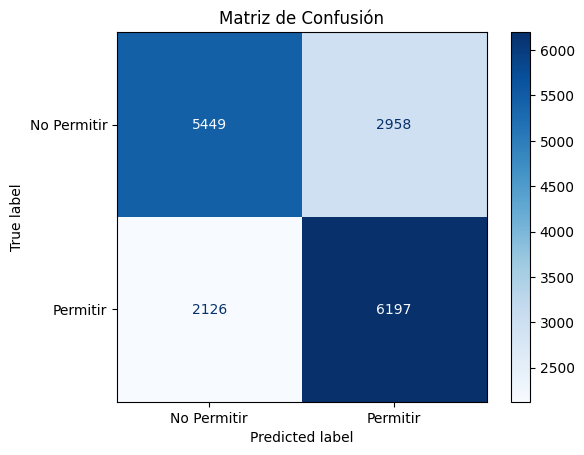

In [46]:
# Mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=best_tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Permitir", "Permitir"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [47]:
# prompt: imprime las reglas de best_tree_clf

from sklearn.tree import export_text

# Imprimir las reglas del mejor árbol de decisión
print("\nReglas del mejor árbol de decisión:")
print(export_text(best_tree_clf, feature_names=X.columns.tolist()))



Reglas del mejor árbol de decisión:
|--- EntradasMensuales <= 1.50
|   |--- PromedioConsumoMensual <= 16892.21
|   |   |--- PromedioConsumoMensual <= 0.62
|   |   |   |--- class: 1
|   |   |--- PromedioConsumoMensual >  0.62
|   |   |   |--- class: 1
|   |--- PromedioConsumoMensual >  16892.21
|   |   |--- PromedioConsumoMensual <= 32462.78
|   |   |   |--- class: 1
|   |   |--- PromedioConsumoMensual >  32462.78
|   |   |   |--- class: 1
|--- EntradasMensuales >  1.50
|   |--- EntradasMensuales <= 2.50
|   |   |--- PromedioConsumoMensual <= 20520.53
|   |   |   |--- class: 0
|   |   |--- PromedioConsumoMensual >  20520.53
|   |   |   |--- class: 0
|   |--- EntradasMensuales >  2.50
|   |   |--- EntradasMensuales <= 3.50
|   |   |   |--- class: 0
|   |   |--- EntradasMensuales >  3.50
|   |   |   |--- class: 0



Si podemos observar, el árbol que tenemos es mucho más consistente en cuasnto a la variable a predecir, por otro lado podemos concluir que independiente del Perfil de Ingreso, lo que incide en la Restricción es el consumo que ha tenido el cliente para que pueda o no usar en el beneficio y el número de entradas que ha tenido hasta el momento. Si observamos los indicadores son mucho más estables pero aun estamos a 70% de accuracy, lo que sugiere que necesitamos más variables para describir la variable objetivo.

## **Conclusiones**

- El ACP nos permitió tener un mejor entendimiento de lo que pasa por los clientes y egenrar una restricción para el beneficio.
- La institución financiera podría ahorrar en el mejor de los casos unos 300k anuales si incluye la restriccción dentro de sus políticas.
- Al trabajar con una muestra balanceada y usar variables complementarias se mejoran los indicadores; sin embargo, es clave manejar un entendimiento de las reglas del árbol y verificar las variables que mas aportan a la prediccón.
- Los clientes que acceden al beneficio lo hacen independiente de su perfil de ingreso.

## **Recomendaciones**

- Se podría sin problema incluir más variables para analizar que influye en la restricción.
- Se podría profundizar en un análisis descriptivo, ya con los outputs del árbol, por ejemplo calcular el promedio de consumo de los clientes que mantiene el beneficio y verificar si este valor es mayor o mejor dque los 16k sugeridos por el árbol.